In [231]:
# notebook settings
%load_ext autoreload
%autoreload 2
# %matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [232]:
# others
import numpy as np

# drake
from pydrake.geometry import SceneGraph
from pydrake.multibody.plant import AddMultibodyPlantSceneGraph
from pydrake.multibody.tree import UniformGravityFieldElement
from pydrake.multibody.plant import MultibodyPlant
from pydrake.multibody.parsing import Parser
from pydrake.systems.framework import DiagramBuilder, BasicVector
from pydrake.systems.analysis import Simulator
from pydrake.systems.meshcat_visualizer import MeshcatVisualizer
from pydrake.systems.drawing import plot_system_graphviz

# hand-written controller
from controller import Controller

In [233]:
builder = DiagramBuilder()
pusher_slider, scene_graph = AddMultibodyPlantSceneGraph(
    builder,
    MultibodyPlant(time_step=0.0003)
)
parser = Parser(plant=pusher_slider)
parser.AddModelFromFile("ground.urdf")
parser.AddModelFromFile("pusher.urdf")
parser.AddModelFromFile("slider.urdf")
# gravity = UniformGravityFieldElement(np.array([0,0,-9.81]))
# pusher_slider.AddForceElement(gravity)
ground = pusher_slider.GetFrameByName('ground_link')
pusher_origin = pusher_slider.GetFrameByName('pusher_x')
world = pusher_slider.world_frame()
pusher_slider.WeldFrames(world, ground)
pusher_slider.WeldFrames(world, pusher_origin)
pusher_slider.Finalize()

In [234]:
controller = builder.AddSystem(Controller(pusher_slider))
builder.Connect(
    pusher_slider.get_state_output_port(),
    controller.get_input_port(0)
)
builder.Connect(
    controller.get_output_port(0),
    pusher_slider.get_actuation_input_port()
)

In [235]:
# first, from terminal: meshcat-server
visualizer = builder.AddSystem(
    MeshcatVisualizer(scene_graph)
)
builder.Connect(
    scene_graph.get_pose_bundle_output_port(),
    visualizer.get_input_port(0)
)
diagram = builder.Build()

Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6000...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/
Connected to meshcat-server.
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6000...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/
Connected to meshcat-server.


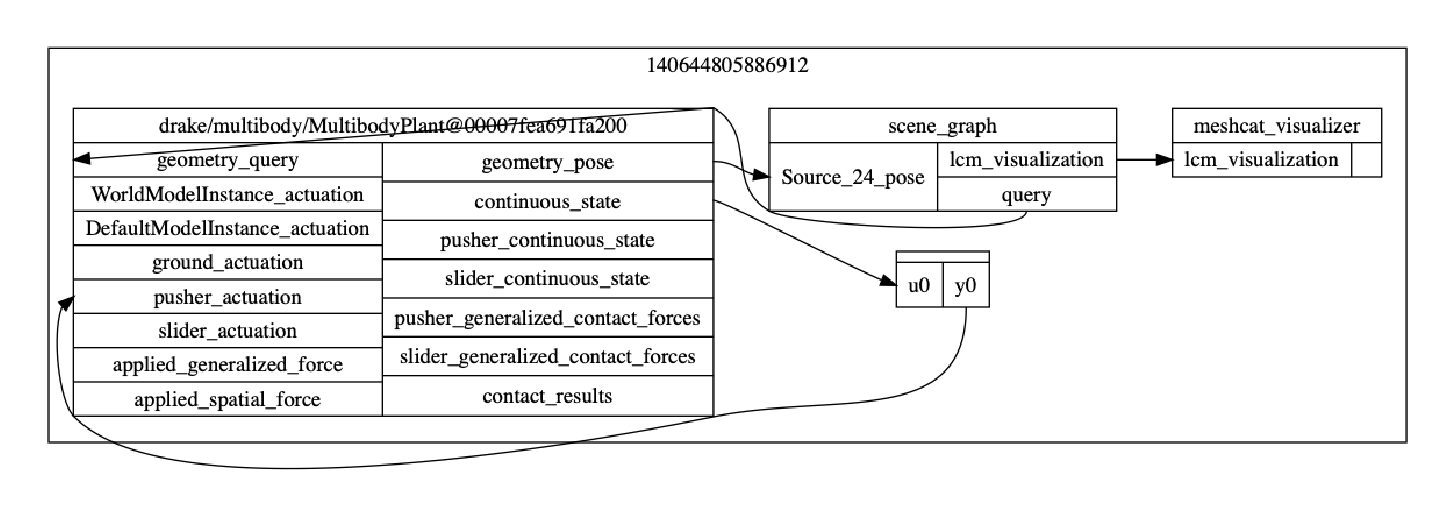

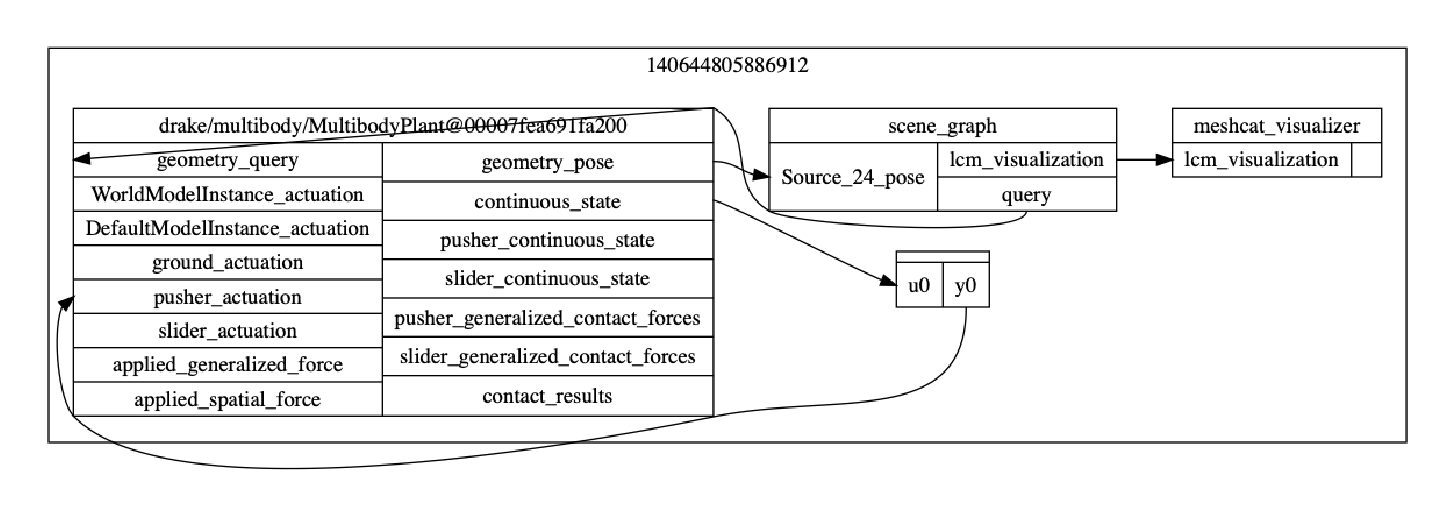

In [236]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 300
plot_system_graphviz(diagram)
plt.show()

In [267]:
diagram_context = diagram.CreateDefaultContext()
pusher_slider_context = diagram.GetMutableSubsystemContext(pusher_slider, diagram_context)
theta = 2
q0 = np.array([
    np.cos(theta/2), 0, 0, np.sin(theta/2), # quaternions slider
    0, 0, .1, # translation slider
    3, -.1 # translation pusher
])
v0 = np.array([0,0,0,0,0,0,0,0])
x0 = np.concatenate((q0, v0))
pusher_slider.SetPositionsAndVelocities(pusher_slider_context, x0)

# pusher_slider_context.FixInputPort(
#     pusher_slider.GetInputPort('pusher_actuation').get_index(), BasicVector([0, 0]))

simulator = Simulator(diagram, diagram_context)
simulator.set_target_realtime_rate(1.0)
# simulator.set_publish_every_time_step(False)
simulator.Initialize()
simulator.StepTo(15)